## Device check

In [1]:
!nvidia-smi

Fri Oct 27 01:29:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:15:00.0 Off |                    0 |
| N/A   27C    P0    40W / 300W |      0MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Packages

In [2]:
import warnings
warnings.filterwarnings(action="ignore")

In [68]:

import lightning.pytorch as pl
import logging
logging.basicConfig(level="INFO")

import math
from matplotlib import pyplot

import numpy as np

import os

import pandas as pd
from pprint import pprint

import sys
sys.path.append("../src")

import timm
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

In [4]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
%load_ext autoreload
%autoreload 2

In [5]:
from einops import pack, unpack, repeat, reduce, rearrange

In [50]:
import config
from dataloader import BEDataset, BEDataModule
import token_learner
from transformer import PositionalEncoder, MultiHeadSelfAttention, MultiHeadCrossAttention, FeedFowardLayer, LayerNormalization, generate_masks, generate_causal_attention_mask

from film_layers import FiLMBlockV2, FiLMEncoder, ResBlockDWConv
from rt1 import RT1Encoder
from utils.data_utils import History
from utils.model_utils import TextEncoder, ImageFeatureExtractor, plot_self_attention, plot_cross_attention


## Data Module

In [7]:
dm = BEDataModule()
dm.setup()

Total # examples: 4876


INFO:root:Training on 3915 samples.
INFO:root:Validating on 961 samples.


## Fetch batch

In [8]:
%%time
sample = next(iter(dm.train_dataloader()))
sample["in_state"].shape

CPU times: user 939 ms, sys: 930 ms, total: 1.87 s
Wall time: 4.91 s


torch.Size([4, 3, 288, 288])

## Model Design

<!-- ![RT1 model architecture](../../imgs/rt1+.png) -->
<center>
    <img src="../imgs/rt1+.png" alt="RT1 model architecture" width="300" height="400">

<center>

### Encoder

#### Test Text Encoder

In [110]:
# te = TextEncoder(freeze=True).cuda()
# summary(model=te, col_names=["num_params", "trainable"])

In [109]:
# emb = te(
#     inp_ids=sample["action_desc"]["ids"].cuda(),
#     mask=sample["action_desc"]["mask"].cuda(),
#     tok_type_ids=sample["action_desc"]["token_type_ids"].cuda()
# )

# emb.shape

torch.Size([4, 512])

#### Test Img Feature Extractor

In [ ]:
# fe = ImageFeatureExtractor(pretrained=True, arch="efficientnet_b3").cuda()

# summary(fe, col_names=["num_params", "trainable"])

In [ ]:
# img_ftrs = fe(sample["in_state"].cuda())

# img_ftrs.shape

#### Test FiLM Block

In [16]:
# film_block = FiLMBlockV2().cuda()
# print(film_block)
# summary(model=film_block)

In [17]:
# text_cond_ftrs = film_block(
#     img_features=img_ftrs, 
#     conditioning=emb
# )

# text_cond_ftrs.shape

#### Test Residual FiLM Block

In [18]:
# dw_res = ResBlockDWConv(512, 512).cuda()
# summary(model=dw_res)

In [19]:
# text_cond_ftrs_res = dw_res(
#     img_features=img_ftrs, 
#     conditioning=emb
# )

# text_cond_ftrs_res.shape

#### Test FiLM Encoder

In [20]:
# film_encoder = FiLMEncoder(
#     arch="resnet34",
#     n_res_blocks=6,
# ).cuda()

# # print(film_encoder)
# summary(model=film_encoder)

In [21]:
# %%time

# out = film_encoder(
#     x= sample["in_state"].cuda(),
#     conditioning= emb
# )

# out.shape

#### Token Learner

In [22]:
# N, C, H_W = out.shape
# N, C, H_W

In [23]:
# tokL_v11 = token_learner.TokenLearnerModuleV11(feature_shape=(N, H_W, C)).cuda()
# print(tokL_v11)
# summary(model=tokL_v11)

In [24]:
# learned_tokens = tokL_v11(out.view(N, H_W, C))
# learned_tokens.shape

In [154]:
tokenized_inputs = torch.empty((B, config.NUM_HISTORY+1, config.D_MODEL, config.NUM_LEARNED_TOKENS))
tokenized_inputs.shape

torch.Size([8, 6, 512, 8])

#### RT-1 Encoder

In [10]:
encoder = RT1Encoder(
    cnn_bacnbone="efficientnet_b3", 
    num_res_blocks=6, 
    freeze_cnn_backbone=True
).to(config.DEVICE)

summary(model=encoder, col_names=["num_params", "trainable"])

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnet_b3.ra2_in1k)
INFO:timm.models._hub:[timm/efficientnet_b3.ra2_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


Layer (type:depth-idx)                                       Param #                   Trainable
RT1Encoder                                                   --                        Partial
├─TextEncoder: 1-1                                           --                        False
│    └─BertModel: 2-1                                        --                        False
│    │    └─BertEmbeddings: 3-1                              (15,891,456)              False
│    │    └─BertEncoder: 3-2                                 (12,609,536)              False
│    │    └─BertPooler: 3-3                                  (262,656)                 False
│    └─Dropout: 2-2                                          --                        --
├─FiLMEncoder: 1-2                                           --                        Partial
│    └─ImageFeatureExtractor: 2-3                            --                        Partial
│    │    └─EfficientNetFeatures: 3-4                        (1

In [11]:
%%time 

src_enc, tokens = encoder._encode(
    input_ids=sample["action_desc"]["ids"].cuda(),
    attn_mask=sample["action_desc"]["mask"].cuda(),
    token_type_ids=sample["action_desc"]["token_type_ids"].cuda(),
    imgs=sample["in_state"].cuda()
)

src_enc.shape, tokens.shape

CPU times: user 965 ms, sys: 975 ms, total: 1.94 s
Wall time: 12.8 s


(torch.Size([4, 512]), torch.Size([4, 512, 8]))

In [12]:
%%time

src_enc, tokenized_inputs = encoder(
    input_ids=sample["action_desc"]["ids"].cuda(),
    attn_mask=sample["action_desc"]["mask"].cuda(),
    token_type_ids=sample["action_desc"]["token_type_ids"].cuda(),
    imgs=sample["in_state"].cuda()
)

tokenized_inputs.shape, tokenized_inputs.device

CPU times: user 202 ms, sys: 51.3 ms, total: 253 ms
Wall time: 1.15 s


(torch.Size([4, 48, 512]), device(type='cuda', index=0))

### Decoder

In [13]:
pos_encoding = PositionalEncoder(seq_len=config.NUM_TOKENIZED_INPUTS).cuda()

In [14]:
pos_enc = pos_encoding(tokenized_inputs)
print(pos_enc.shape)

learned_tokens = tokenized_inputs + pos_enc

torch.Size([4, 48, 512])


#### Test Cross Attention Layer

In [73]:
num_heads = 4
cross_attention = MultiHeadCrossAttention(
    embed_dim=512, 
    num_heads=num_heads, 
    dropout_rate=0.1
).cuda()

print(cross_attention)
summary(cross_attention)

MultiHeadCrossAttention(
  (attention_heads): ModuleList(
    (0-3): 4 x CrossAttentionHead(
      (w_k_input): Linear(in_features=512, out_features=512, bias=False)
      (w_v_input): Linear(in_features=512, out_features=512, bias=False)
      (w_q_output): Linear(in_features=512, out_features=512, bias=False)
      (dropout): Dropout(p=0.15, inplace=False)
      (_softmax): Softmax(dim=-1)
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (_softmax): Softmax(dim=-1)
)


Layer (type:depth-idx)                   Param #
MultiHeadCrossAttention                  --
├─ModuleList: 1-1                        --
│    └─CrossAttentionHead: 2-1           --
│    │    └─Linear: 3-1                  262,144
│    │    └─Linear: 3-2                  262,144
│    │    └─Linear: 3-3                  262,144
│    │    └─Dropout: 3-4                 --
│    │    └─Softmax: 3-5                 --
│    └─CrossAttentionHead: 2-2           --
│    │    └─Linear: 3-6                  262,144
│    │    └─Linear: 3-7                  262,144
│    │    └─Linear: 3-8                  262,144
│    │    └─Dropout: 3-9                 --
│    │    └─Softmax: 3-10                --
│    └─CrossAttentionHead: 2-3           --
│    │    └─Linear: 3-11                 262,144
│    │    └─Linear: 3-12                 262,144
│    │    └─Linear: 3-13                 262,144
│    │    └─Dropout: 3-14                --
│    │    └─Softmax: 3-15                --
│    └─CrossAttentionHead:

In [52]:
input_seq_embedding = encoder.text_encoder.text_encoder.embeddings.cuda()

print(input_seq_embedding)
summary(input_seq_embedding)

BertEmbeddings(
  (word_embeddings): Embedding(30522, 512, padding_idx=0)
  (position_embeddings): Embedding(512, 512)
  (token_type_embeddings): Embedding(2, 512)
  (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


Layer (type:depth-idx)                   Param #
BertEmbeddings                           --
├─Embedding: 1-1                         (15,627,264)
├─Embedding: 1-2                         (262,144)
├─Embedding: 1-3                         (1,024)
├─LayerNorm: 1-4                         (1,024)
├─Dropout: 1-5                           --
Total params: 15,891,456
Trainable params: 0
Non-trainable params: 15,891,456

In [53]:
target_seq_embedding = nn.Sequential(
    nn.Embedding(
        num_embeddings=config.TARGET_VOCAB_SIZE, 
        embedding_dim=config.EMBEDDING_DIM, 
        padding_idx=config.TGT_PAD_TOK_ID
    ),
    LayerNormalization(),
    nn.Dropout(p=.1)
    
).cuda()
cross_attention.eval()

print(target_seq_embedding)
summary(target_seq_embedding)


Sequential(
  (0): Embedding(52, 512, padding_idx=2)
  (1): LayerNormalization(
    (layer): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
  )
  (2): Dropout(p=0.1, inplace=False)
)


Layer (type:depth-idx)                   Param #
Sequential                               --
├─Embedding: 1-1                         26,624
├─LayerNormalization: 1-2                --
│    └─LayerNorm: 2-1                    1,024
├─Dropout: 1-3                           --
Total params: 27,648
Trainable params: 27,648
Non-trainable params: 0

In [54]:
inp = sample["action_desc"]["ids"]
outp = sample["motor_cmd"]["ids"]

inp_seq = input_seq_embedding(inp.cuda())
outp_seq = target_seq_embedding(outp.cuda())
inp_seq_lens = sample["action_desc"]["length"]
outp_seq_lens = sample["motor_cmd"]["length"]

inp_seq.shape, outp_seq.shape,inp_seq_lens, outp_seq_lens

(torch.Size([4, 16, 512]),
 torch.Size([4, 16, 512]),
 tensor([7, 4, 7, 8]),
 tensor([11,  8, 11, 11]))

In [55]:
inp, inp.shape

(tensor([[  101,  2404,  1996,  9292,  1999,  2392,  1997,  4605,   102,     0,
              0,     0,     0,     0,     0,     0],
         [  101,  2693,  1996,  5835,  2157,   102,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0],
         [  101,  2404,  1996,  2452,  2006,  2327,  1997,  2630,  1011,  3384,
           1011,  5127,   102,     0,     0,     0],
         [  101,  2404,  1996,  5835,  2000,  1996,  2187,  1997,  6350,  1011,
          20943,   102,     0,     0,     0,     0]]),
 torch.Size([4, 16]))

In [56]:
outp, outp.shape

(tensor([[ 0,  7, 31, 50, 21, 41, 36,  7, 44, 21,  2,  2,  2,  2,  2,  2],
         [ 0,  8, 41, 51,  8, 48,  8,  2,  2,  2,  2,  2,  2,  2,  2,  2],
         [ 0, 25, 41, 30,  4, 31, 36, 25, 42,  4,  2,  2,  2,  2,  2,  2],
         [ 0,  8, 31, 50, 13, 46, 36,  8, 43, 13,  2,  2,  2,  2,  2,  2]]),
 torch.Size([4, 16]))

In [77]:
attention_output, attention_w = cross_attention(inp_seq, inp_seq_lens, outp_seq)

attention_output.shape, attention_w.shape

attn scores:  torch.Size([4, 16, 16])
inp mask:  torch.Size([4, 16])
attn scores:  torch.Size([4, 16, 16])
inp mask:  torch.Size([4, 16])
attn scores:  torch.Size([4, 16, 16])
inp mask:  torch.Size([4, 16])
attn scores:  torch.Size([4, 16, 16])
inp mask:  torch.Size([4, 16])


(torch.Size([4, 16, 4, 512]), torch.Size([4, 4, 16, 16]))

#### Plot Cross attention weights

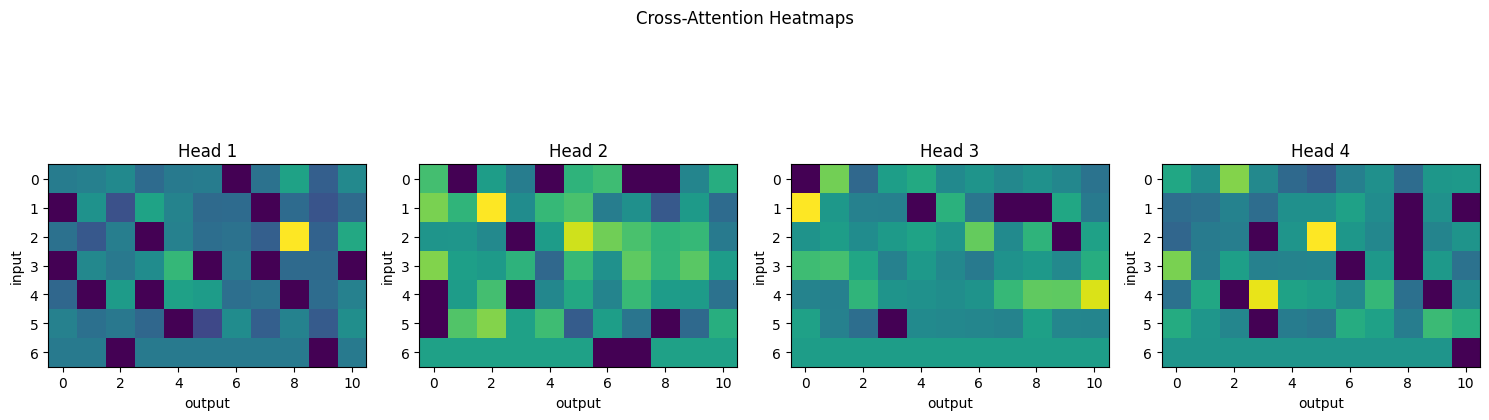

In [78]:
# plot_cross_attention(attention_w, inp_seq_lens=inp_seq_lens, outp_seq_lens=outp_seq_lens)
plot_cross_attention(attention_w, inp_seq_lens=inp_seq_lens, outp_seq_lens=outp_seq_lens, example_idx=2)

#### Test MultiHeadAttention Layer

In [33]:
mhsa = MultiHeadSelfAttention().cuda()
print(mhsa)
summary(mhsa)

MultiHeadSelfAttention(
  (attention_heads): ModuleList(
    (0-7): 8 x SelfAttentionHead(
      (dropout): Dropout(p=0.15, inplace=False)
      (_softmax): Softmax(dim=-1)
      (w_q): Linear(in_features=512, out_features=512, bias=False)
      (w_k): Linear(in_features=512, out_features=512, bias=False)
      (w_v): Linear(in_features=512, out_features=512, bias=False)
    )
  )
  (output_layer): Sequential(
    (0): Linear(in_features=4096, out_features=512, bias=False)
    (1): Dropout(p=0.15, inplace=False)
  )
)


Layer (type:depth-idx)                   Param #
MultiHeadSelfAttention                   --
├─ModuleList: 1-1                        --
│    └─SelfAttentionHead: 2-1            --
│    │    └─Dropout: 3-1                 --
│    │    └─Softmax: 3-2                 --
│    │    └─Linear: 3-3                  262,144
│    │    └─Linear: 3-4                  262,144
│    │    └─Linear: 3-5                  262,144
│    └─SelfAttentionHead: 2-2            --
│    │    └─Dropout: 3-6                 --
│    │    └─Softmax: 3-7                 --
│    │    └─Linear: 3-8                  262,144
│    │    └─Linear: 3-9                  262,144
│    │    └─Linear: 3-10                 262,144
│    └─SelfAttentionHead: 2-3            --
│    │    └─Dropout: 3-11                --
│    │    └─Softmax: 3-12                --
│    │    └─Linear: 3-13                 262,144
│    │    └─Linear: 3-14                 262,144
│    │    └─Linear: 3-15                 262,144
│    └─SelfAttentionHead: 

In [34]:
mem, attn_w = mhsa(inp=learned_tokens, return_weights=True)

mem.shape, attn_w.shape

Concat in: torch.Size([4, 48, 8, 512])
Concat flat: torch.Size([4, 48, 4096])


(torch.Size([4, 48, 512]), torch.Size([4, 8, 48, 48]))

#### Plot Self-attention weights

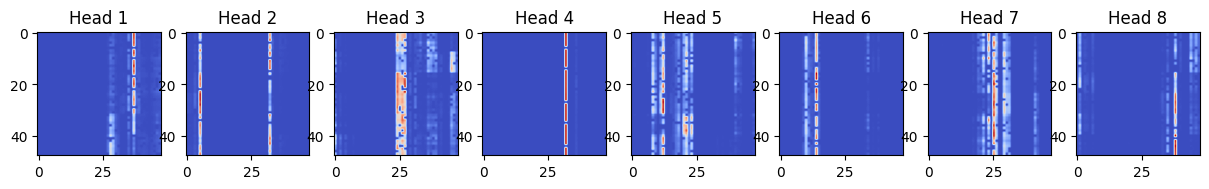

In [35]:
# plot_self_attention(attn_w)
plot_self_attention(attn_w, example_idx=2)

#### Transformer Decoder Layer

In [116]:
class TransformerDecoderLayer(nn.Module):
    def __init__(
        self, 
        d_model:int=config.D_MODEL, 
        n_selfattention_heads:int=config.N_HEADS, 
        n_crossattention_heads:int=config.N_HEADS,
        dim_feedforward:int=config.D_FF, 
        dropout:float=config.DECODER_DROPOUT_RATE
    ):
        super().__init__()

        # Multi-head self-attention
        self.self_attn = MultiHeadSelfAttention(num_heads=n_selfattention_heads)
        
        # Multi-head Cross-attention
        self.cross_attn = MultiHeadCrossAttention(num_heads=n_crossattention_heads)
        
        # Layer normalization 1
        self.norm1 = LayerNormalization()
        
        # Layer normalization 2
        self.norm2 = LayerNormalization()
        
        # Position-wise feed-forward network
        self.ff = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.GELU(),
            nn.Linear(dim_feedforward, d_model)
        )
        
        # Layer normalization after feed-forward
        self.norm3 = nn.LayerNorm(d_model)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)

    def forward(
        self, 
        tokens:torch.Tensor, 
        inp_lens:torch.Tensor,
        self_mask:torch.Tensor=None, 
        cross_mask:torch.tensor=None,
        return_weights:bool=True,
        debug:bool=False
    ):
        
        inp = tokens # reserve this for cross attention
        
        if debug:
            print(f"inp shape: {inp.shape}")
        # Layer normalization 1
        inp_ = self.norm1(inp)
        if debug:
            print(f"LN 1 out shape: {inp_.shape}")

        # Multi-head self-attention
        self_attn_W = None
        self_attn_output = self.self_attn(inp_, mask=self_mask)
        
        if return_weights:
            inp_, self_attn_W = self_attn_output
        else:
            inp_ = self_attn_output
        
        if debug:
            print(f"MHSA out : {inp_.shape}")
        # Apply dropout and add the residual connection
        tokens = tokens + self.dropout(inp_)
        
        # Layer normalization 2
        out = self.norm2(tokens)
        if debug:
            print(f"LN 2 out shape: {out.shape}")
        # Apply FF
        ff_out = self.dropout(self.ff(out))
        if debug:
            print(f"FF out shape: {ff_out.shape}")
        # Add the residual connection
        tokens = tokens + ff_out
        
        # compute cross attention between encoder's outputs and decoder's prev. hidden states
        cross_attn_out, cross_attn_W = self.cross_attn(inp, inp_lens, tokens, apply_mask=cross_mask)
        
        if debug:
            print(f"MHCA out : {cross_attn_out.shape}")
        
        if debug:
            print(f"Final out shape: {tokens.shape}")
            
        return tokens, self_attn_W, cross_attn_W


#### Test Transformer decoder layer

In [117]:
dec_layer = TransformerDecoderLayer().cuda()
print(dec_layer)
summary(dec_layer)

TransformerDecoderLayer(
  (self_attn): MultiHeadSelfAttention(
    (attention_heads): ModuleList(
      (0-7): 8 x SelfAttentionHead(
        (dropout): Dropout(p=0.15, inplace=False)
        (_softmax): Softmax(dim=-1)
        (w_q): Linear(in_features=512, out_features=512, bias=False)
        (w_k): Linear(in_features=512, out_features=512, bias=False)
        (w_v): Linear(in_features=512, out_features=512, bias=False)
      )
    )
    (output_layer): Sequential(
      (0): Linear(in_features=4096, out_features=512, bias=False)
      (1): Dropout(p=0.15, inplace=False)
    )
  )
  (cross_attn): MultiHeadCrossAttention(
    (attention_heads): ModuleList(
      (0-7): 8 x CrossAttentionHead(
        (w_k_input): Linear(in_features=512, out_features=512, bias=False)
        (w_v_input): Linear(in_features=512, out_features=512, bias=False)
        (w_q_output): Linear(in_features=512, out_features=512, bias=False)
        (dropout): Dropout(p=0.15, inplace=False)
        (_softmax):

Layer (type:depth-idx)                   Param #
TransformerDecoderLayer                  --
├─MultiHeadSelfAttention: 1-1            --
│    └─ModuleList: 2-1                   --
│    │    └─SelfAttentionHead: 3-1       786,432
│    │    └─SelfAttentionHead: 3-2       786,432
│    │    └─SelfAttentionHead: 3-3       786,432
│    │    └─SelfAttentionHead: 3-4       786,432
│    │    └─SelfAttentionHead: 3-5       786,432
│    │    └─SelfAttentionHead: 3-6       786,432
│    │    └─SelfAttentionHead: 3-7       786,432
│    │    └─SelfAttentionHead: 3-8       786,432
│    └─Sequential: 2-2                   --
│    │    └─Linear: 3-9                  2,097,152
│    │    └─Dropout: 3-10                --
├─MultiHeadCrossAttention: 1-2           --
│    └─ModuleList: 2-3                   --
│    │    └─CrossAttentionHead: 3-11     786,432
│    │    └─CrossAttentionHead: 3-12     786,432
│    │    └─CrossAttentionHead: 3-13     786,432
│    │    └─CrossAttentionHead: 3-14     786,432
│   

In [118]:
dec_out, self_attn_w, cross_attn_w = dec_layer(learned_tokens, inp_lens=inp_seq_lens, debug=False)
dec_out.shape, self_attn_w.shape, cross_attn_w.shape

(torch.Size([4, 48, 512]),
 torch.Size([4, 8, 48, 48]),
 torch.Size([4, 8, 48, 48]))

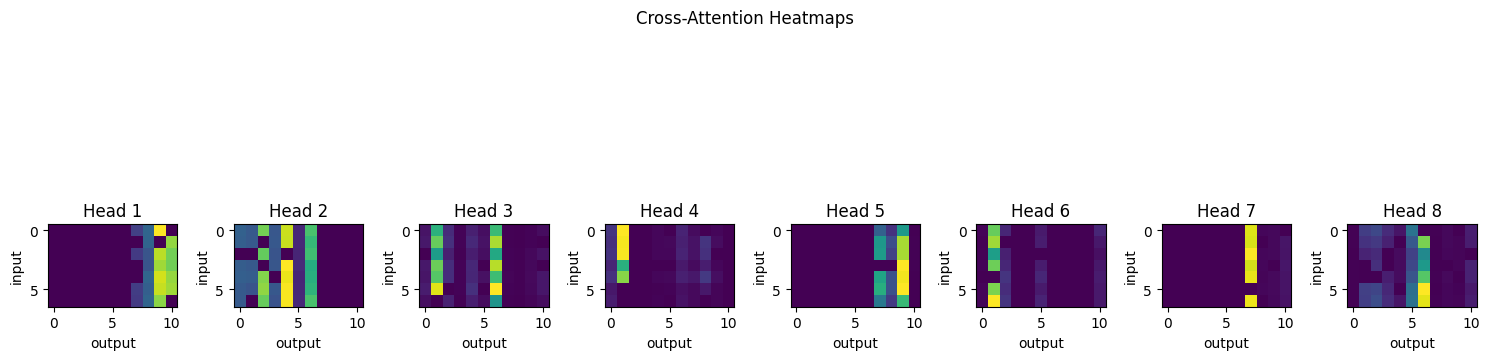

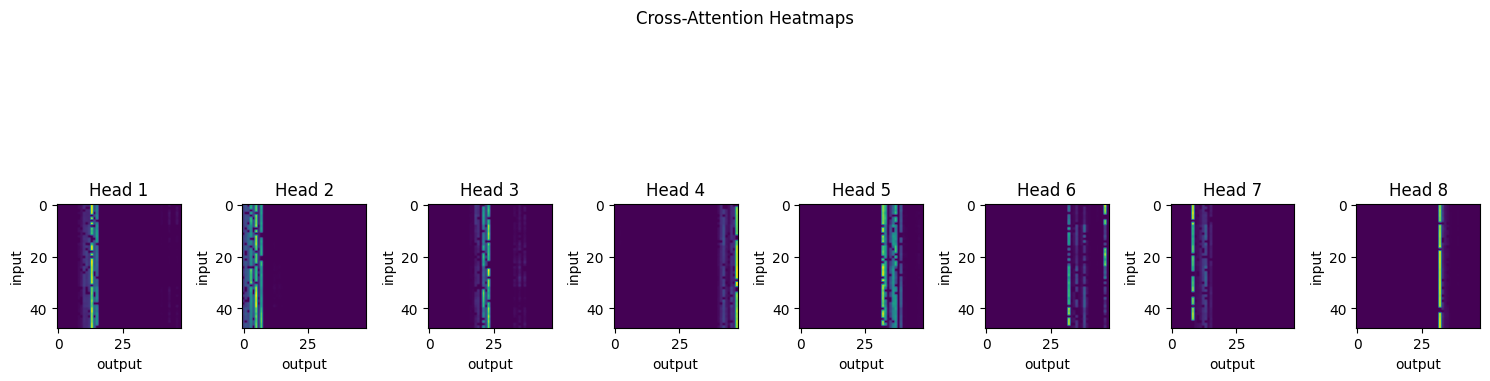

In [119]:
plot_cross_attention(cross_attn_w, inp_seq_lens=inp_seq_lens, outp_seq_lens=outp_seq_lens)
plot_cross_attention(cross_attn_w)

#### Transformer decoder

In [120]:
class TransformerDecoder(nn.Module):
    def __init__(
        self, 
        num_layers:int=config.N_DECODER_LAYERS
    ):
        super().__init__()
        
        self.num_layers = num_layers

        # token embedding
        self.token_embedding = nn.Linear(
            in_features=config.NUM_TOKENIZED_INPUTS, 
            out_features=config.EMBEDDING_DIM
        )
               
        # transformer layers
        self.layers = nn.ModuleList([
            TransformerDecoderLayer()
            for _ in range(num_layers)
        ])
        
        self._initialize()
    
    def _initialize(self):
        
        # Glorot / fan_avg. Initialization
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform(p)
            
    def forward(
        self, 
        inp:torch.Tensor, 
        self_mask:torch.Tensor=None, 
        cross_mask:torch.Tensor=None, 
        debug:bool=False
    ):
        
        B, T, D = inp.shape
        
        # positions = torch.eye(T).repeat(B, 1, 1)
        
        # embed tokens
        inp = self.token_embedding(inp)
        
        # run attention self-attention modules
        attn_Ws = []
        for layer in self.layers:
            inp, attn_W = layer(inp, mask=mask)
            if attn_W is not None:
                attn_Ws.append(attn_W)
                
        return inp, attn_Ws

#### Test Transformer decoder

In [ ]:
dec = TransformerDecoder(num_layers=1)
summary(model=dec)

Layer (type:depth-idx)                             Param #
TransformerDecoder                                 --
├─Linear: 1-1                                      25,088
├─ModuleList: 1-2                                  --
│    └─TransformerDecoderLayer: 2-1                --
│    │    └─MultiHeadSelfAttention: 3-1            8,388,608
│    │    └─MultiHeadCrossAttention: 3-2           6,291,456
│    │    └─LayerNormalization: 3-3                1,024
│    │    └─LayerNormalization: 3-4                1,024
│    │    └─Sequential: 3-5                        2,099,712
│    │    └─LayerNorm: 3-6                         1,024
│    │    └─Dropout: 3-7                           --
Total params: 16,807,936
Trainable params: 16,807,936
Non-trainable params: 0

#### Test Transformer Decoder

In [ ]:
dec_out = dec(
    src=src_enc, 
    encoder_outputs=tokens,
    y=None #sample["motor_cmd"]["ids"].cuda()
)

In [ ]:
src_enc.shape

#### Action Generator

In [251]:
class ActionGenerator(nn.Module):
    def __init__(
        self,
        d_model:int=config.D_MODEL, 
        vocab_size:int=len(config.TARGETS),
        action_bins:int=config.ACTION_BINS,
        num_actons:int=config.NUM_ACTION_SLOTS
    ):
        super().__init__()
        
        # attrs
        self.action_bins = action_bins
        
        # layers
        self.norm = LayerNormalization()
        self.proj = nn.Linear(in_features=d_model, out_features=vocab_size)
        self._softmax = nn.LogSoftmax(dim=-1)

    def forward(self, tokens):
        
        out = self.norm(tokens)
        out = self.proj(out)
        out = self._softmax(out)
        
        return out
    

In [252]:
generator = ActionGenerator().cuda()
print(generator)
summary(generator)

ActionGenerator(
  (norm): LayerNormalization(
    (layer): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
  )
  (proj): Linear(in_features=512, out_features=52, bias=True)
  (_softmax): LogSoftmax(dim=-1)
)


Layer (type:depth-idx)                   Param #
ActionGenerator                          --
├─LayerNormalization: 1-1                --
│    └─LayerNorm: 2-1                    1,024
├─Linear: 1-2                            26,676
├─LogSoftmax: 1-3                        --
Total params: 27,700
Trainable params: 27,700
Non-trainable params: 0

In [ ]:
N, C, T = tokens.shape

N, C, T

In [ ]:
actions = generator(tokens.view(N, T, C))

actions.shape

### RT-1 Decoder

In [ ]:
class RT1Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.positional_encoder = PositionalEncoder()
        self.transformer = TransformerDecoder()
        self.action_generator = ActionGenerator()
        
    def _decode_predictions(self, preds, method:str="greedy"):
        """
            Args:
                preds: predictions (logits)
                method: decoding strategy. one of ["greedy", "beam-search"]
                
            Returns:
                actions: decoded predictions as sequence of actions.
            
        """
        pass
    
    def forward(self, learned_tokens):
        
        # positional encoding
        pos_enc = self.positional_encoder(imgs)
        
        # Generate attention mask
        attention_mask = generate_causal_attention_mask()
        # Add positional encoding
        pos_enc = pos_encoding(learned_tokens)
        # print(pos_enc.shape)
        learned_tokens = learned_tokens + pos_enc
        # Attend to learned tokens
        attended_tokens = self.transformer(learned_tokens, mask = ~attention_mask)
        out = reduce(attended_tokens, 'b (f n) d -> b f d', 'mean', f = (config.NUM_HISTORY + 1))
        
        # generate outputs
        logits = self.action_generator(out)
        
        return logits

### RT-1 

In [ ]:
class RT1(pl.LightningModule):
    def __init__(
        self
    ):
        super().__init__()
        self.encoder = RT1Encder()
        self.decoder = RT1Decoder()
        self.input_seq_embedding = self.encoder.text_encoder.text_encoder.embeddings
        # freeze BERT Embedding layer
        for param in self.input_seq_embedding.parameters():
            param.requires_grad = False 
            
        self.target_seq_embedding = nn.Sequential(
            nn.Embedding(
                num_embeddings=config.TARGET_VOCAB_SIZE, 
                embedding_dim=config.EMBEDDING_DIM, 
                padding_idx=config.TGT_PAD_TOK_ID
            ),
            LayerNormalization(),
            nn.Dropout(p=.1)

        )
        self.cross_attention_module = MultiHeadCrossAttention(num_heads=4)
        
    def forward(self, input_ids, attn_mask, token_type_ids, imgs):
        
        tokens = self.encode(input_ids, attn_mask, token_type_ids, imgs)
        out = self.decode(tokens, )
    
    def encode(self, input_ids, attn_mask, token_type_ids, imgs):
        return self.encoder(input_ids, attn_mask, token_type_ids, imgs)
    
    def decode(self, enc_outputs, x_mask, y, y_mask):
        return self.decoder(y, enc_outputs, src_mask, tgt_mask)
    
    def configure_optimizers(self):
        pass
    
    def training_step(self, batch, batch_idx):
        pass
    
    def validation_step(self, batch, batch_idx):
        pass
    
    def test_step(self, batch, batch_idx):
        pass
    
    def compute_loss(self, outputs, targets):
        pass